In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score

In [4]:
# 원전 내부의 충돌체 정보를 네개의 센서 정보만으로 특정해내기
# 데이터 출처 : https://dacon.io/competitions/official/235614/overview/description/
train_features = pd.read_csv('D:/Data/KAERI_dataset/train_features.csv')
train_target = pd.read_csv('D:/Data/KAERI_dataset/train_target.csv')

In [5]:
train_features.shape, train_target.shape

((1050000, 6), (2800, 5))

In [6]:
train_features.head() #학습 데이터의 feature 확인

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [7]:
train_features.isnull().sum() # 결측치 확인.

id      0
Time    0
S1      0
S2      0
S3      0
S4      0
dtype: int64

In [8]:
train_target.head() #학습 데이터의 target 확인

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4


In [9]:
train_target.isnull().sum() # 결측치 확인

id    0
X     0
Y     0
M     0
V     0
dtype: int64

#### -- Data Preprocessing

In [10]:
# 앞서 수행했던 데이터 전처리 및 feature engineering을 수행해주는 함수
def feature_eng_df(data):
  cond = (data['S1'] != 0) | (data['S2'] != 0) | (data['S3'] != 0) | (data['S4'] != 0)

  data_active = data[cond]

  data_active = data_active.drop_duplicates(['id'],keep='first')
  for n in data_active.index:
    for s in ['S1','S2','S3','S4']:
      data_active.loc[n,'delta_'+s] = data.loc[n+1,'S1']-data.loc[n,'S1']

  for s in ['S1','S2','S3','S4']:
    min_s = data.groupby(by='id').min()[s]
    max_s = data.groupby(by='id').max()[s]
    gap_s = max_s - min_s
    gap_s = gap_s.reset_index()
    gap_s.columns = ['id','gap_'+s]
    data_active = data_active.merge(gap_s,on='id')

  data_active['Time'] = (data_active['Time']*10**6).astype('int')

  data[(data['S2'] != 0)].drop_duplicates(['id'],keep='first')[['id','Time']]

  for s in ['S1','S2','S3','S4']:
    cond = (data[s] != 0)
    active_time = data[cond].drop_duplicates(['id'],keep='first')[['id','Time']]
    active_time['Time'] = (active_time['Time']*10**6).astype('int')
    active_time.columns = ['id','active_time_'+s]
    data_active = data_active.merge(active_time,on='id')

  data_active['R12'] = (data_active['active_time_S1']+data_active['active_time_S2'])/(data_active['active_time_S3']+data_active['active_time_S4'])
  data_active['R13'] = (data_active['active_time_S1']+data_active['active_time_S3'])/(data_active['active_time_S2']+data_active['active_time_S4'])
  data_active['R14'] = (data_active['active_time_S1']+data_active['active_time_S4'])/(data_active['active_time_S2']+data_active['active_time_S3'])

  data_active['RMS_S'] = (data_active['S1']**2+data_active['S2']**2+data_active['S3']**2+data_active['S4']**2)**0.5
  data_active['RMS_delta'] = (data_active['delta_S1']**2+data_active['delta_S2']**2+data_active['delta_S3']**2+data_active['delta_S4']**2)**0.5
  data_active['RMS_gap'] = (data_active['gap_S1']**2+data_active['gap_S2']**2+data_active['gap_S3']**2+data_active['gap_S4']**2)**0.5
  data_active['RMS_time'] = (data_active['active_time_S1']**2+data_active['active_time_S2']**2+data_active['active_time_S3']**2+data_active['active_time_S4']**2)**0.5

  return data_active

In [11]:
df_features = feature_eng_df(train_features)
df_features.head()

,id,Time,S1,S2,S3,S4,delta_S1,delta_S2,delta_S3,delta_S4,...,active_time_S2,active_time_S3,active_time_S4,R12,R13,R14,RMS_S,RMS_delta,RMS_gap,RMS_time
0,0,40,-4.972607e-08,-4.972607e-08,0.0,0.0,-9.540139e-07,-9.540139e-07,-9.540139e-07,-9.540139e-07,...,40,112,88,0.400000,1.187500,0.842105,7.032328e-08,0.000002,1.050503e+06,153.257952
1,1,20,0.000000e+00,-4.104924e-07,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,20,72,56,1.000000,2.368421,1.782609,4.104924e-07,0.000000,5.190467e+06,142.772546
2,2,16,-9.210808e-05,0.000000e+00,0.0,0.0,-6.751038e-03,-6.751038e-03,-6.751038e-03,-6.751038e-03,...,88,88,68,0.666667,0.666667,0.477273,9.210808e-05,0.013502,9.394777e+05,142.716502
3,3,32,0.000000e+00,-1.783159e-07,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,32,72,48,0.900000,1.850000,1.192308,1.783159e-07,0.000000,1.777999e+06,119.532422
4,4,20,3.230998e-07,0.000000e+00,0.0,0.0,1.472695e-05,1.472695e-05,1.472695e-05,1.472695e-05,...,92,80,56,0.823529,0.675676,0.441860,3.230998e-07,0.000029,1.922468e+06,135.646600


In [12]:
# target과 feature이름들을 모아서 리스트로 만들어 두자
targets = list(train_target.columns)[1:]
features = list(df_features.columns)[1:]

In [13]:
df = df_features.merge(train_target,on='id')
df.head()

,id,Time,S1,S2,S3,S4,delta_S1,delta_S2,delta_S3,delta_S4,...,R13,R14,RMS_S,RMS_delta,RMS_gap,RMS_time,X,Y,M,V
0,0,40,-4.972607e-08,-4.972607e-08,0.0,0.0,-9.540139e-07,-9.540139e-07,-9.540139e-07,-9.540139e-07,...,1.187500,0.842105,7.032328e-08,0.000002,1.050503e+06,153.257952,0.0,-400.0,50.0,0.4
1,1,20,0.000000e+00,-4.104924e-07,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.368421,1.782609,4.104924e-07,0.000000,5.190467e+06,142.772546,400.0,0.0,100.0,1.0
2,2,16,-9.210808e-05,0.000000e+00,0.0,0.0,-6.751038e-03,-6.751038e-03,-6.751038e-03,-6.751038e-03,...,0.666667,0.477273,9.210808e-05,0.013502,9.394777e+05,142.716502,-300.0,-200.0,25.0,0.4
3,3,32,0.000000e+00,-1.783159e-07,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.850000,1.192308,1.783159e-07,0.000000,1.777999e+06,119.532422,200.0,-100.0,150.0,0.4
4,4,20,3.230998e-07,0.000000e+00,0.0,0.0,1.472695e-05,1.472695e-05,1.472695e-05,1.472695e-05,...,0.675676,0.441860,3.230998e-07,0.000029,1.922468e+06,135.646600,-300.0,-100.0,150.0,0.4


In [14]:
# 데이터를 학습용, 검증용으로 분리
# 이렇게보니 사이즈가 확 줄었다.
df_train, df_val = train_test_split(df[1:],test_size=0.2,train_size=0.8,random_state=2)
df_train.shape, df_val.shape, df.shape

((2239, 29), (560, 29), (2800, 29))

In [15]:
y_train = df_train[targets]
X_train = df_train.drop(['id']+targets,axis=1)

y_val = df_val[targets]
X_val = df_val.drop(['id']+targets,axis=1)

In [16]:
# dacon에서 제공하는 평가 지표 함수. 낮을 수록 좋은 값.
def kaeri_metric(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: KAERI metric
    '''    
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)

### E1과 E2는 아래에 정의됨 ###

def E1(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)

def E2(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
        
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))

#### -- 좀 더 들여다보기

<AxesSubplot:xlabel='Time', ylabel='S4'>

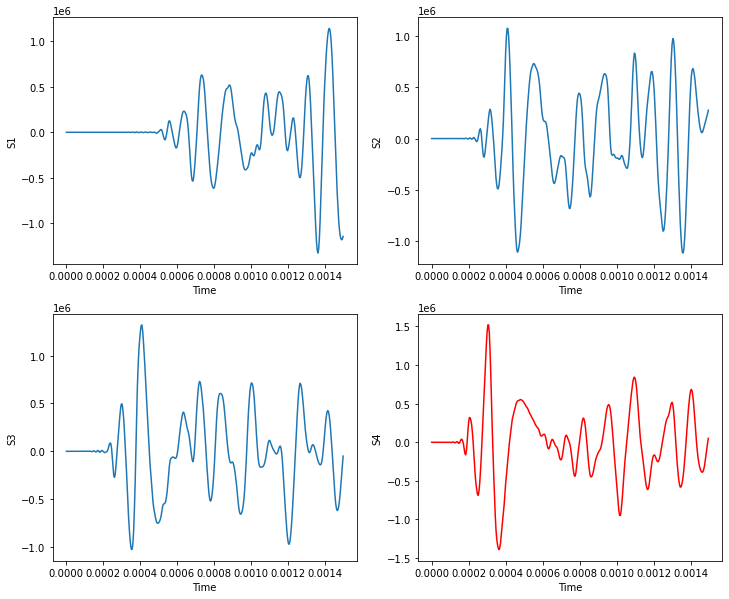

In [17]:
# 같은 인덱스(같은 충돌체)의 센서 정보를 시각화 해서 비교
# 이 파장들을 푸리에 트랜스폼 시켜서, 근사적으로 amplitude가 큰 경우만 몇가지 추려내 feature로 쓸 수 있을까?
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.lineplot(data=train_features.loc[train_features['id']==644],x='Time',y='S1')

plt.subplot(2,2,2)
sns.lineplot(data=train_features.loc[train_features['id']==644],x='Time',y='S2')

plt.subplot(2,2,3)
sns.lineplot(data=train_features.loc[train_features['id']==644],x='Time',y='S3')

plt.subplot(2,2,4)
sns.lineplot(data=train_features.loc[train_features['id']==644],x='Time',y='S4')


In [18]:
# numpy에서 Fast Fourier Transform을 사용, 원하는 만큼만 잘라낼 수 있게 함수 설정
def fourier_trsf(data,sensor,id=0,cutoff=20):
    cond_id = data['id']==id
    wave = data.loc[cond_id,sensor]
    time = data.loc[cond_id,'Time']
    fft_wave = np.fft.fft(wave)
    freq = np.fft.fftfreq(time.shape[-1])

    cw = np.copy(fft_wave)
    cw[cutoff:-cutoff]=0
    fft_wave_2 = np.real(np.fft.ifft(cw))
    
    return {"fft":fft_wave, "freq":freq, "fft_cutoff":fft_wave_2, "time":time, "wave":wave}

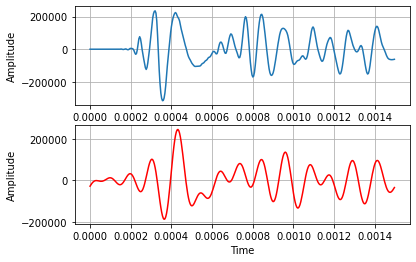

In [19]:
# cutoff 15로, 진동수 15개만을 남겨도 꽤 유사한 모습이 된다
# 물론 이렇게 해도, 각 센서별로 변수가 진동수, 진폭, 위상차로 3x15=45가지씩 늘어난다. 총 180개가 추가되는 셈
# 가장 진폭이 큰 진동수와 위상차만 남겨봐야 하나...?
w0 = fourier_trsf(data=train_features,sensor='S1',id=0,cutoff=15)

fig, ax = plt.subplots(2, 1)

ax[0].plot(w0['time'], w0['wave'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)

ax[1].plot(w0['time'], w0['fft_cutoff'], 'r') 
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)

plt.show()

#### -- Baseline Model

: X, Y, M, V 각각의 평균 값을 기준 모델로 사용

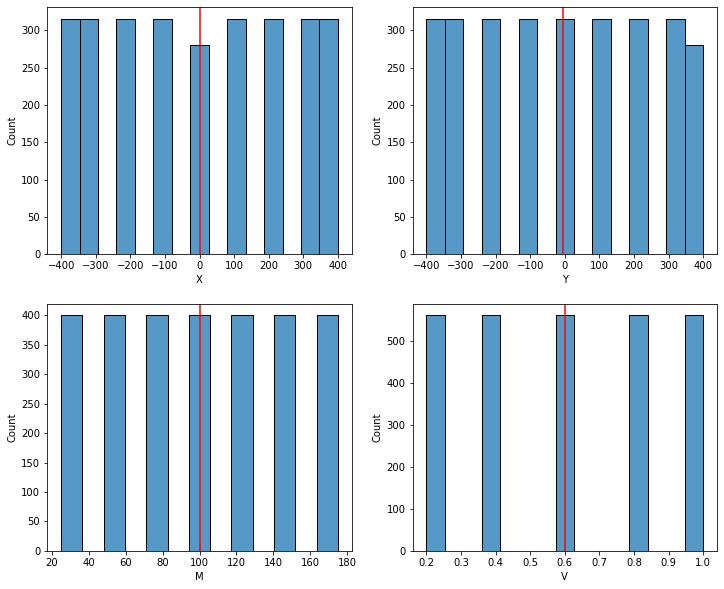

In [20]:
# 타겟의 분포를 한번 살펴보자
# 대부분 고르게 퍼져있는 모습을 보여준다
# 기준 모델은 평균으로 잡아서 사용하는 것이 적절해보인다
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.histplot(train_target['X'])
plt.axvline(train_target['X'].mean(),color='r')
plt.subplot(2,2,2)
sns.histplot(train_target['Y'])
plt.axvline(train_target['Y'].mean(),color='r')
plt.subplot(2,2,3)
sns.histplot(train_target['M'])
plt.axvline(train_target['M'].mean(),color='r')
plt.subplot(2,2,4)
sns.histplot(train_target['V'])
plt.axvline(train_target['V'].mean(),color='r')

In [21]:
# 평균을 기준모델로 잡았다
y_train_base_pred = [y_train.mean()]*len(y_train)
y_val_base_pred = [y_train.mean()]*len(y_val)

In [22]:
# train data에서 기준모델의 성능 (MAE, MSE)
base_train_mae = mean_absolute_error(y_train,y_train_base_pred)
base_train_mse = mean_squared_error(y_train,y_train_base_pred)
base_train_kaeri = kaeri_metric(y_train,y_train_base_pred)
base_train_mae, base_train_mse, base_train_kaeri

(121.46452784602639, 33474.589719622076, 4.481603675176487)

In [23]:
# validation data에서 기준모델의 성능 (MAE, MSE)
base_val_mae = mean_absolute_error(y_val,y_val_base_pred)
base_val_mse = mean_squared_error(y_val,y_val_base_pred)
base_val_kaeri = kaeri_metric(y_val,y_val_base_pred)
base_val_mae, base_val_mse, base_val_kaeri

(125.40301326325543, 35445.72163732173, 4.723035136755175)

#### -- RandomForest Model

In [24]:
# regressor와 데이터를 받아서 학습하고, MAE와 MSE, feature importance를 시각화 시켜준다
def make_model(regressor,feature_list,data_train,target_train,data_val,target_val):
  train_X = data_train[feature_list]
  val_X = data_val[feature_list]
  train_y = target_train
  val_y = target_val

  regressor.fit(train_X,train_y)

  train_y_pred = regressor.predict(train_X)
  val_y_pred = regressor.predict(val_X)
  kaeri_score_train = kaeri_metric(train_y,train_y_pred)
  kaeri_score_val = kaeri_metric(val_y,val_y_pred)
  mae_train = mean_absolute_error(train_y,train_y_pred)
  mae_val = mean_absolute_error(val_y,val_y_pred)
  mse_train = mean_squared_error(train_y,train_y_pred)
  mse_val = mean_squared_error(val_y,val_y_pred)

  print("train score \n","kaeri_metric:",kaeri_score_train, "mae:",mae_train,"mse:",mse_train)
  print("val score \n","kaeri_metric:",kaeri_score_val, "mae:",mae_val,"mse:",mse_val)

  plt.figure(figsize=(10,len(regressor.feature_importances_)))
  pd.Series(regressor.feature_importances_,train_X.columns).sort_values().plot.barh()

  return kaeri_score_train, mae_train, mse_train, kaeri_score_val, mae_val, mse_val 

In [25]:
# RandomForestRegressor를 만든다
model = RandomForestRegressor(max_depth=14,min_samples_split=2,min_samples_leaf=1,criterion='mae',max_features='sqrt',n_estimators=1000,oob_score=True,random_state=2)

train score 
 kaeri_metric: 0.037822217235854244 mae: 3.061607268870031 mse: 38.96506300525569
val score 
 kaeri_metric: 0.19041213335256238 mae: 6.747338526785715 mse: 195.60325205795976


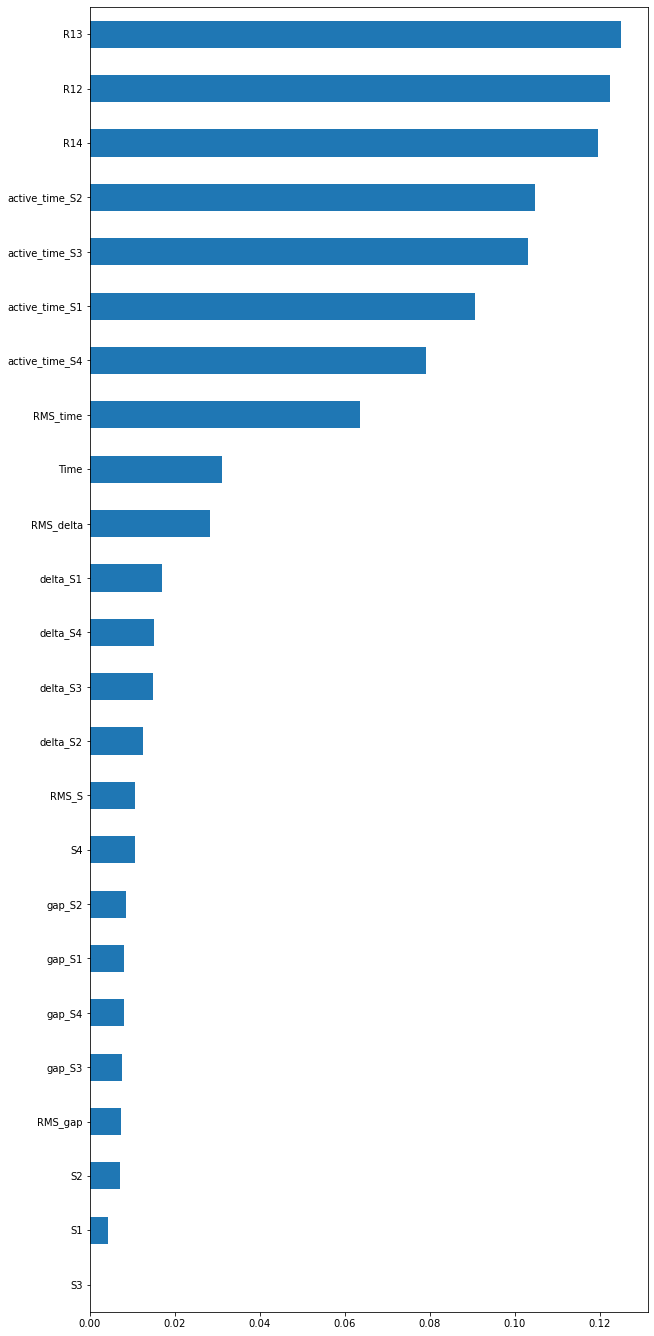

In [26]:
# 주어진 Feature를 넣고서 학습. 결과 확인
model_score = make_model(model,features,X_train,y_train,X_val,y_val)

In [27]:
# 세가지 score 모두 확실히 RF로 학습한 모델이 훨씬 작은 값을 보여준다
base_vs_rf = pd.DataFrame([['RF']+list(model_score),['Base',base_train_kaeri,base_train_mae, base_train_mse, base_val_kaeri, base_val_mae, base_val_mse]],columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val'])
base_vs_rf

,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,RF,0.037822,3.061607,38.965063,0.190412,6.747339,195.603252
1,Base,4.481604,121.464528,33474.589720,4.723035,125.403013,35445.721637


#### -- Xgboost model

In [28]:
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import xgboost
from sklearn.multioutput import MultiOutputRegressor

In [29]:
# XGB모델 설정 타겟이 네가지라, multioutput regressor를 사용.
multi_xgb = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,max_depth=7)) #,colsample_bytree=1)

In [30]:
# XGB에 사용하기 위해서, array 형태로 전부 변환
dX_train = X_train.to_numpy()
dX_val = X_val.to_numpy()
dy_train = y_train.to_numpy()
dy_val = y_val.to_numpy()

In [31]:
multi_xgb.fit(dX_train,dy_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.08,
                                            max_delta_step=None, max_depth=7,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, reg_alpha=None,
                                            

In [32]:
y_train_pred_xgb = multi_xgb.predict(dX_train)

In [33]:
y_val_pred_xgb = multi_xgb.predict(dX_val)

In [34]:
# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)
xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val

(0.01676907316226785,
 2.0270003827798564,
 28.688113230552233,
 0.12135764618225085,
 4.150493259276389,
 127.63092834349892)

In [35]:
xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
xgb_score

,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.016769,2.027,28.688113,0.121358,4.150493,127.630928


In [36]:
# 베이스라인, RF, XGB의 결과값 비교
# 전반적으로, xgboost를 쓴 것이, RF를 사용한 것 보다, 성능이 향상 되었다.
xgb_vs_rf = pd.concat([xgb_score,base_vs_rf])
xgb_vs_rf

,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.016769,2.027,28.688113,0.121358,4.150493,127.630928
0,RF,0.037822,3.061607,38.965063,0.190412,6.747339,195.603252
1,Base,4.481604,121.464528,33474.58972,4.723035,125.403013,35445.721637


#### -- Permuataion Importances

In [43]:
import eli5
from eli5.sklearn import PermutationImportance

In [44]:
# permuter 생성 후, dX_val, y_val를 넣고 각 feature를 permutation해가면서 확인
permuter = PermutationImportance(
    multi_xgb,
    scoring='neg_mean_absolute_error', 
    n_iter=5, 
    random_state=2
)
permuter.fit(dX_val, y_val);

In [45]:
# R12, R13, R14가 가장 큰 importance를 보여준다.
# delta_S는 S1하나만 빼고는 0이다
# S3도 0이 나왔다
# 특정 센서가 더 중요할 이유가 없다고 판단하면, 현재 타겟 X, Y의 분포에서 약간 차이나는 부분에서 나온 오차로 같은 종류의 feature에서도 특정 센서만 importance가 다른 것일 거라 추측된다
# delta_S의 경우는 하나만 제외하고는 0이 나왔으니, 제외 해도 괜찮을 것 같다. 특별히 delta_S1이 큰 값을 갖는 것도 아니기 때문에 과적합의 요인이 될 수 있을 것으로 보인다.
pd.Series(permuter.feature_importances_, features).sort_values(ascending=False)

R12               68.915733
R14               41.438794
R13               32.004638
RMS_time          14.378130
RMS_gap            4.530582
active_time_S1     3.908457
Time               3.778683
active_time_S2     3.204759
RMS_S              2.096841
active_time_S3     2.068890
active_time_S4     1.786463
gap_S3             1.087651
S4                 0.993755
gap_S1             0.487443
gap_S2             0.358707
gap_S4             0.339557
S2                 0.090757
S1                 0.088481
delta_S1           0.087804
RMS_delta          0.066513
delta_S4           0.000000
delta_S2           0.000000
S3                 0.000000
delta_S3           0.000000
dtype: float64